In [27]:
# Read the dataset

test_set_path = r"data\bigdatasets\mnist\mnist_test.csv"
train_set_path = r"data\bigdatasets\mnist\mnist_train.csv"

import csv
import torch
import torch.nn.functional as F


def read_csv(path: str, read_rows: int = None):
    # Reads the csv and returns a list of lists
    # The first row is the header and is ignored
    # The csv contains 29 columns the first one is the label and the rest are the pixels

    xs, ys = [], []
    with open(path, "r") as f:
        reader = csv.reader(f, delimiter=",")
        next(reader) # skip the header
        for row in reader:
            ys.append(int(row[0]))
            xs.append([float(x) for x in row[1:]])

            if read_rows is not None and len(xs) >= read_rows:
                break
            
    xs = torch.tensor(xs, dtype=torch.float32)
    ys =  F.one_hot(torch.tensor(ys), num_classes=10)

    return xs.view((-1,28,28)), ys.float()


train_xs, train_ys = read_csv(train_set_path)
test_xs, test_ys = read_csv(test_set_path)

train_xs.shape, train_ys.shape, test_xs.shape, test_ys.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000, 10]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000, 10]))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


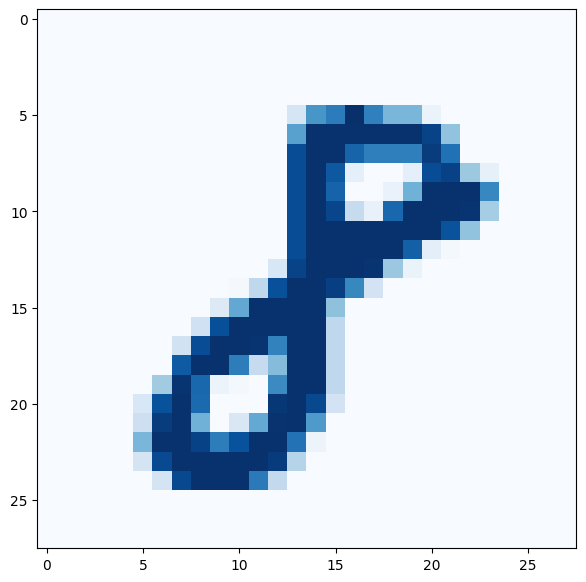

In [28]:
# Visualize the dataset
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(7,7))

print(train_ys[31])
plt.imshow(train_xs[31], cmap='Blues')


In [29]:
# Build the training harness
from custom_torch.nn import *
from enum import Enum


class Trainer:

    class Mode(Enum):
        TRAIN = 1
        FIND_LR = 2


    def __init__(self, model: Module, xs: torch.Tensor, ys: torch.Tensor, loss_fn, batch_size=32):
        self.__learning_rate = 0.01
        self.model = model
        self.xs = xs
        self.ys = ys
        self.loss_fn = loss_fn
        self.batch_size = batch_size

        # Tracking
        self.losses = []


    @property
    def learning_rate(self):
        if len(self.losses) > 100_000:
            return 0.001
        
        return self.__learning_rate

    def train(self):
        batch_idx = torch.randint(0,self.xs.shape[0], (self.batch_size,))

        x = self.xs[batch_idx]
        y = self.ys[batch_idx]

        logits = self.model(x)
        loss = self.loss_fn(logits, y)

        for param in self.model.parameters:
            param.grad = None

        loss.backward()

        for param in self.model.parameters:
            param.data -= self.learning_rate * param.grad


        return loss.item()
    
    def run(self, epoch = 10_000):
        for i in range(epoch):
            loss = self.train()
            if i % 10_000 == 0:
                print(f"Epoch {i} loss: {loss}")

            self.losses.append(loss)


        



# MLP model
- Architecture
  - 784 input neurons
  - 64 hidden neurons
  - 64 hidden neurons
  - Softmax output layer with 10 neurons

In [65]:
# Build the model

n_hidden_1 = 64
n_hidden_2 = 64


model = Sequential(
    FlattenConsecutive(28),
    Linear(28*28, n_hidden_1), Tanh(), #BatchNorm(n_hidden_1),
    Linear(n_hidden_1, n_hidden_2), Tanh(), #BatchNorm(n_hidden_2),
    Linear(n_hidden_2, 10)
)

for p in model.parameters:
    p.requires_grad = True
    print(p.shape)

print("Total parameters:", sum(p.numel() for p in model.parameters))

trainer = Trainer(model, train_xs, train_ys, F.cross_entropy , batch_size=256)


torch.Size([784, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 10])
torch.Size([10])
Total parameters: 55050


In [66]:

trainer.run(epoch=100_000)

Epoch 0 loss: 2.4444727897644043
Epoch 10000 loss: 0.14548301696777344
Epoch 20000 loss: 0.11995182931423187
Epoch 30000 loss: 0.10830473154783249
Epoch 40000 loss: 0.09678421914577484
Epoch 50000 loss: 0.05868829786777496
Epoch 60000 loss: 0.05269816517829895
Epoch 70000 loss: 0.10232172906398773
Epoch 80000 loss: 0.08490315079689026
Epoch 90000 loss: 0.020459892228245735


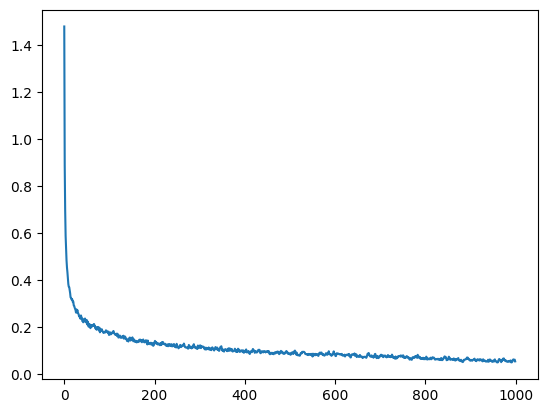

In [67]:
plt.plot(torch.tensor(trainer.losses).view(-1,100).mean(dim=1))

In [68]:
# Test the model

@torch.no_grad()
def test(model, xs, ys):
    logits = model(xs)
    loss = F.cross_entropy(logits, ys)

    preds = torch.argmax(logits, dim=1)
    labels = torch.argmax(ys, dim=1)

    accuracy = (preds == labels).float().mean()
    print(f"Accuracy: {accuracy.item()}")
    print(f"Loss: {loss.item()}")



test(model, train_xs, train_ys)
test(model, test_xs, test_ys)



Accuracy: 0.9827166795730591
Loss: 0.05541297793388367
Accuracy: 0.9645000100135803
Loss: 0.12197837233543396


In [76]:
@torch.no_grad()
def predict(model, xs, ys):
    logits = model(xs.view((1,28,28)))
    preds = torch.argmax(logits, dim=1)
    label = torch.argmax(ys).item()

    # print(f"Prediction:{preds.item()}, Label:{label}")
    return preds.item() == label


success = 0
for x, y in zip(test_xs, test_ys):
    if predict(model, x, y):
        success += 1

print(f"Success rate: {success / len(test_xs)}")
    

Success rate: 0.9645
